# 16 hidden dimensions

In [1]:
import torch
from torch import nn
from torch.optim import Adam
from matplotlib import pyplot as plt
from matplotlib import cm
import pandas as pd
from tqdm.notebook import tqdm
import numpy as np

from physics_mi.utils import set_all_seeds

In [2]:
seed = np.random.randint(1, 2**32 - 1)
# seed = 2694658690
set_all_seeds(seed)
print(seed)

3667279864


## Model

Keeping this extremely simple

In [3]:
class LinearLayer(nn.Module):
    def __init__(self, in_feats, out_feats, use_act=True, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.linear = nn.Linear(in_feats, out_feats)
        if use_act:
            self.act = nn.ReLU()
        self.use_act = use_act

    def forward(self, x):
        x = self.linear(x)
        if self.use_act:
            x = self.act(x)
        return x


class Net(nn.Module):
    def __init__(self, use_act=True, dim=32, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.layers = nn.Sequential(
            LinearLayer(2, dim, use_act=use_act),
            LinearLayer(dim, 1, use_act=False),
        )

    def forward(self, x):
        return self.layers(x)

## Data

Going to sample $x_1$ (mass) and $x_2$ (acceleration) such that their product is uniformly distributed.

In [4]:
eps = 0.5

Y = torch.rand(10000)
X = torch.empty(10000, 2)
X[:, 0] = Y / (torch.rand(10000) * (1 - eps) + eps)
X[:, 1] = Y / X[:, 0]

# need to randomly swap x1 and x2 so that they're identically distributed - can do this because their product is commutative
mask = torch.rand(10000) < 0.5
swap_vals = X[:, 0][mask]
X[:, 0][mask] = X[:, 1][mask]
X[:, 1][mask] = swap_vals

assert torch.allclose(X[:, 0] * X[:, 1], Y)

Y = Y[:, None]
X.shape, Y.shape

(torch.Size([10000, 2]), torch.Size([10000, 1]))

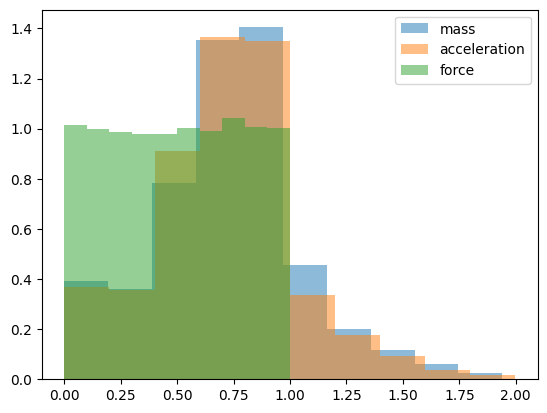

In [5]:
fig, ax = plt.subplots()

ax.hist(X[:, 0], alpha=0.5, density=True, label="mass")
ax.hist(X[:, 1], alpha=0.5, density=True, label="acceleration")
ax.hist(Y[:, 0], alpha=0.5, density=True, label="force")
ax.legend()

In [6]:
s_inds = np.random.permutation(range(X.shape[0]))  # shuffled indices

X_train = X[s_inds[:8000]]
Y_train = Y[s_inds[:8000]]
X_valid = X[s_inds[8000:]]
Y_valid = Y[s_inds[8000:]]

X_train.shape, Y_train.shape, X_valid.shape, Y_valid.shape

(torch.Size([8000, 2]),
 torch.Size([8000, 1]),
 torch.Size([2000, 2]),
 torch.Size([2000, 1]))

## Training

I'll just do full gradient descent to keep things simple.

In [7]:
N = 4000  # number of epochs

model = Net(use_act=True, dim=16)  # 16D here we go
loss_func = nn.MSELoss()
optimiser = Adam(model.parameters(), lr=1e-2)
log = []

for i in tqdm(range(N)):
    log_sample = {}

    # Training update
    model.train()
    model.zero_grad()
    Y_hat = model(X_train)
    loss = loss_func(Y_hat, Y_train)
    log_sample["train_loss"] = float(loss.detach())
    loss.backward()
    optimiser.step()

    # Validation set
    model.eval()
    Y_hat = model(X_valid)
    loss = loss_func(Y_hat, Y_valid)
    log_sample["valid_loss"] = float(loss.detach())

    log.append(log_sample)

df = pd.DataFrame(log)

  0%|          | 0/4000 [00:00<?, ?it/s]

## Results

In [8]:
def plot_loss(train_loss, valid_loss):
    _, ax = plt.subplots()

    ax.plot(train_loss, label="train")
    ax.plot(valid_loss, label="valid")
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Loss")
    ax.legend()


def get_preds(model):
    model.eval()

    with torch.inference_mode():
        out = model(X_valid)

    y_preds = out.flatten().numpy()
    y_targs = Y_valid.flatten().numpy()

    return y_preds, y_targs


def get_valid_loss(model, loss_func):
    model.eval()

    with torch.inference_mode():
        out = model(X_valid)

    return loss_func(out, Y_valid)


def plot_results(y_preds, y_targs):
    _, ax = plt.subplots()

    ax.scatter(y_preds, y_targs, s=4, label="predictions")
    ax.plot(y_targs, y_targs, color="salmon", ls="--", lw=0.5, label="perfect accuracy")
    ax.set(xlabel="y_preds", ylabel="y_targs")
    ax.legend()

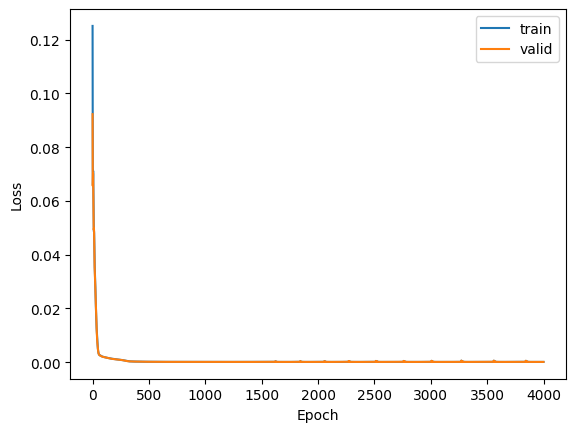

In [9]:
plot_loss(df["train_loss"], df["valid_loss"])

In [10]:
y_preds, y_targs = get_preds(model)

In [11]:
get_valid_loss(model, loss_func)

tensor(0.0001)

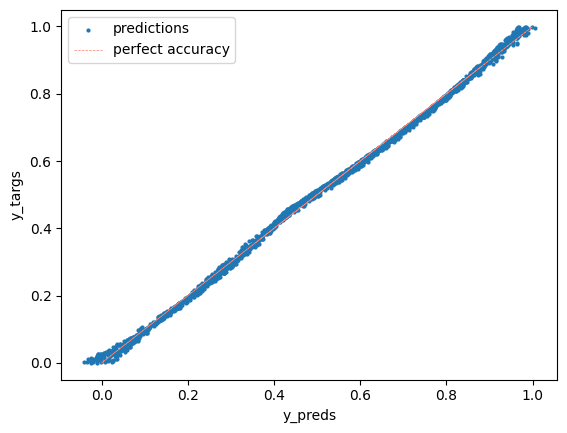

In [12]:
plot_results(y_preds, y_targs)

## Introspection

In [13]:
model

Net(
  (layers): Sequential(
    (0): LinearLayer(
      (linear): Linear(in_features=2, out_features=16, bias=True)
      (act): ReLU()
    )
    (1): LinearLayer(
      (linear): Linear(in_features=16, out_features=1, bias=True)
    )
  )
)

In [14]:
for name, param in model.named_parameters():
    print(name, "\n", param.data, "\n")

layers.0.linear.weight 
 tensor([[-0.5374, -0.5257],
        [-0.1882, -0.4562],
        [ 0.7210,  0.7323],
        [ 0.9988, -0.9121],
        [-0.0254, -0.0644],
        [-0.4750,  0.5335],
        [-0.1459,  0.7916],
        [ 0.5755,  0.6908],
        [-0.5151,  0.5172],
        [ 0.2720,  0.6271],
        [-0.2920, -0.2997],
        [-0.2290, -0.5552],
        [ 0.5833,  0.0698],
        [-0.4452, -0.0161],
        [ 0.2229,  0.7354],
        [-0.3738, -0.2613]]) 

layers.0.linear.bias 
 tensor([ 2.6997e-01, -5.8247e-01, -9.9277e-01,  3.9648e-01,  4.1860e-01,
         1.9482e-01,  2.2434e-01,  4.8831e-01, -5.6851e-04,  3.1955e-01,
         6.8997e-01, -5.3788e-01,  1.4489e-01, -5.6375e-01,  3.0458e-01,
        -2.3172e-01]) 

layers.1.linear.weight 
 tensor([[ 0.0215, -0.0468,  0.4876, -0.2532, -0.1068, -0.4680,  0.0622,  0.2093,
         -0.4313,  0.1106, -0.2408,  0.1448,  0.2156,  0.1357,  0.3706,  0.1775]]) 

layers.1.linear.bias 
 tensor([-0.1254]) 



### Inspect intermediate values

In [15]:
SD = model.state_dict()

In [16]:
from collections import OrderedDict
import torch
import torch.nn as nn


def capture_intermediate_outputs(model, input_tensor):
    """
    Captures the intermediate outputs of a PyTorch model.

    Args:
        model: A PyTorch model.
        input_tensor: A PyTorch tensor of shape (batch_size, *).
    Returns:
        A dictionary mapping layer names to intermediate outputs.
    """
    intermediate_values = OrderedDict()

    def hook_fn(module, input, output, name):
        if isinstance(module, nn.Linear):
            weight = module.weight
            input_value = input[0]
            intermediate_output = input_value.matmul(weight.t())
            intermediate_values[f"{name}.weight"] = intermediate_output
            intermediate_values[f"{name}.bias"] = output
        else:
            intermediate_values[name] = output

    hooks = []
    for name, layer in model.named_modules():
        hook = layer.register_forward_hook(
            lambda module, input, output, name=name: hook_fn(module, input, output, name)
        )
        hooks.append(hook)

    with torch.inference_mode():
        _ = model(input_tensor)

    for hook in hooks:
        hook.remove()

    filtered_values = {k: t for k, t in intermediate_values.items() if len(k.split(".")) > 2}
    return filtered_values


# a function that uses capture_intermediate_outputs to give a nice printed summary of the model outputs and parameters
def print_model_summary(model, input_tensor):
    intermediate_values = capture_intermediate_outputs(model, input_tensor)

    for k, v in intermediate_values.items():
        print(f"{k}: {v}")

In [17]:
def plot_model_breakdown(
    x1, x2, dim1, dim2, point_selector, ax=None, legend=True, color=None, product_color=False, lines=True
):
    """
    Plots the breakdown of a model's output into its intermediate components.

    Args:
        x1: The first input value.
        x2: The second input value.
        point_selector: A dictionary mapping layer names to booleans. If a layer name is in the dictionary, then the corresponding point will be plotted.
        ax: A matplotlib axes object.
        legend: Whether to show the legend.
        color: The color of the points.
        product_color: Whether to color the points by the product of x1 and x2.
        lines: Whether to draw lines between the points.
    Returns:
        The matplotlib axes object.
    """
    if not ax:
        fig = plt.figure()
        ax = plt.axes()

    input = (x1, x2)

    if not color and product_color:
        val = x1 * x2
        cmap = cm.plasma
        val = val**0.5  # looks better on the unit square with some scaling
        color = cmap(val)

    x = capture_intermediate_outputs(model, torch.tensor([x1, x2]).float())
    dim = list(x.values())[1].shape[0]
    x = {k: t.tolist() for k, t in x.items()}
    x = {**{"input": list(input)}, **x}
    x = {
        k: (t + (dim - len(t)) * [0.0] if len(t) < dim else t) for k, t in x.items()
    }  # pad with 0s for input and near-output values

    markers = {k: "o" for k, _ in x.items()}
    markers["input"] = "v"
    markers[list(x.keys())[-1]] = "x"

    for point_name, point in x.items():
        if point_selector[point_name]:
            point = [point[dim1], point[dim2]]
            ax.scatter(*point, alpha=1.0, label=point_name, color=color, marker=markers[point_name])

    x_arr = np.array(list(x.values()))

    if lines:
        ax.plot(*x_arr.T, lw=0.5, color=color)
    ax.set(xlabel="component 0", ylabel="component 1")
    if legend:
        ax.legend()


def get_colors(N):
    cmap = plt.get_cmap("turbo", N)
    colors = []
    for i in range(cmap.N):
        colors.append(cmap(i))
    return colors


def get_default_point_selector_sets():
    subsets = []
    for i in range(6):
        subset = {
            "input": False,
            "layers.0.linear.weight": False,
            "layers.0.linear.bias": False,
            "layers.0.act": False,
            "layers.1.linear.weight": False,
            "layers.1.linear.bias": True,
        }
        subset[list(subset.keys())[i]] = True
        subsets.append(subset)
    subsets[0]["input"] = True
    return subsets


def plot_subsets(dim1, dim2, axes=None):
    """
    Plots the breakdown of a model's output into its intermediate outputs.

    Args:
        return_fig: Whether to return the figure and axes objects.
    Returns:
        The matplotlib figure and axes objects.
    """
    if axes is None:
        fig, axes = plt.subplots(5, 1, figsize=(10, 70))

    N = 5
    pairs = np.concatenate(np.stack(np.meshgrid(np.linspace(0, 1, N), np.linspace(0, 1, N))).T)

    subsets = get_default_point_selector_sets()

    titles = list(subsets[0].keys())[:-1]

    for ax, subset, title in zip(axes.flatten(), subsets, titles):
        plot_model_breakdown(*pairs[0], dim1, dim2, ax=ax, product_color=True, point_selector=subset, lines=False)
        for pair in pairs[1:]:
            plot_model_breakdown(
                *pair, dim1, dim2, ax=ax, legend=False, product_color=True, point_selector=subset, lines=False
            )
        ax.vlines(0, -2, 2, color="gray", ls="--", lw=0.5)
        ax.hlines(0, -2, 2, color="gray", ls="--", lw=0.5)
        ax.set_title(title)
        ax.set_aspect("equal")

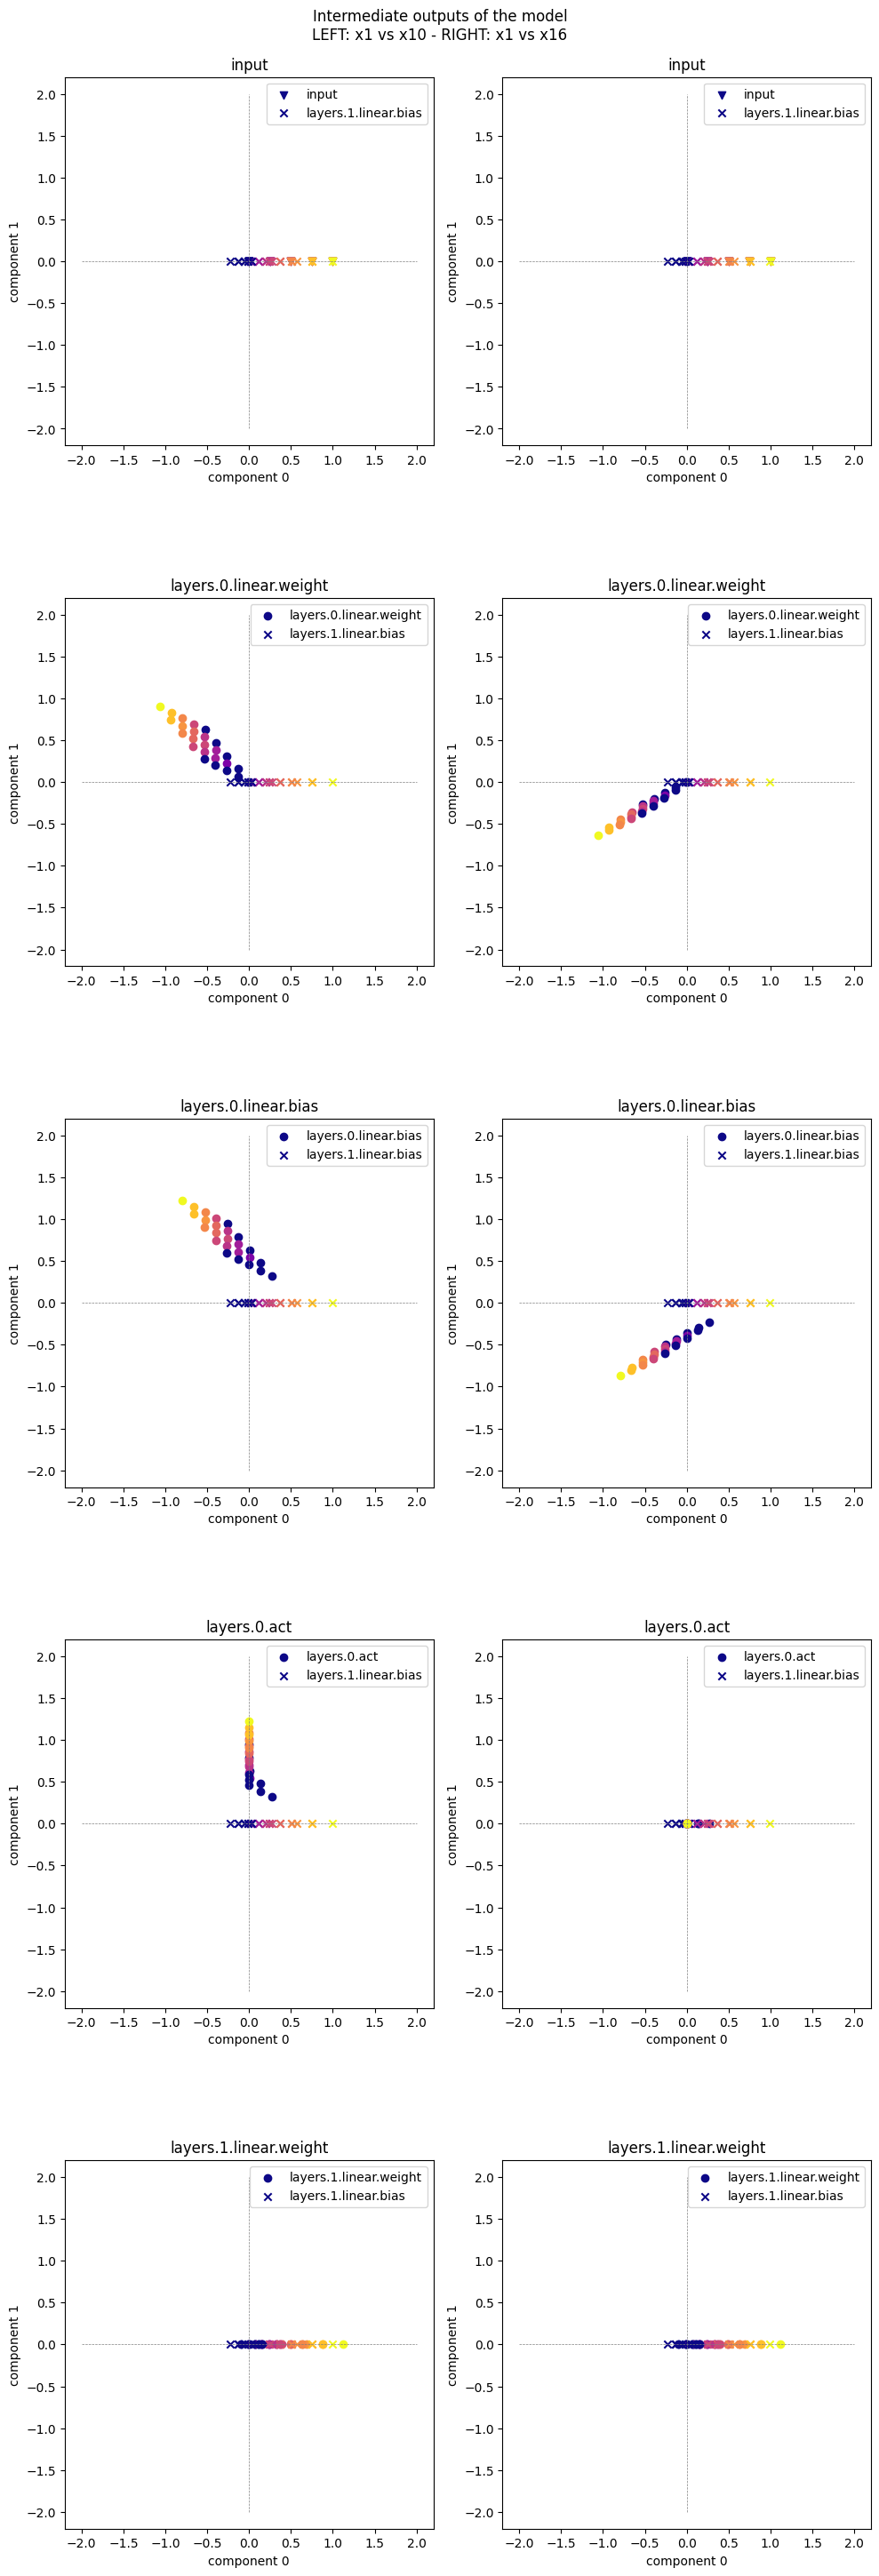

In [22]:
fig, axes = plt.subplots(5, 2, figsize=(10, 30))

dims = [(0, 9), (0, 15)]

plot_subsets(dim1=dims[0][0], dim2=dims[0][1], axes=axes[:, 0])
plot_subsets(dim1=dims[1][0], dim2=dims[1][1], axes=axes[:, 1])

fig.suptitle(
    f"Intermediate outputs of the model\nLEFT: x{dims[0][0]+1} vs x{dims[0][1]+1} - RIGHT: x{dims[1][0]+1} vs x{dims[1][1]+1}"
)
fig.tight_layout()

Obviously, with this many dimensions, it's kind of hard to see what's going on _but_ we are expecting behaviour where each node selectively deals with a different part of the unit square - sort of a divide and conquer.

For each node, there will be "active" and "inactive" regions of the unit square i.e. regions of the unit square for which the node will return non-zero values and regions where it will return 0 values at `layers.0.linear.act`.

We could predict that for the network to perform well at this task, as we have been intuitively getting at throughout these experiments, the nodes will not share the same active and inactive regions but they will be roughly distributed amongst them. I'm going to see if I can produce activity plots for each node and we can test this hypothesis (with some quantitative measures too).

First, our unit square:

In [23]:
N = 5
pairs = np.concatenate(np.stack(np.meshgrid(np.linspace(0, 1, N), np.linspace(0, 1, N))).T)

In [34]:
outputs = capture_intermediate_outputs(model, torch.as_tensor(pairs).float())
acts = outputs["layers.0.act"]  # these are the ones we're interested in

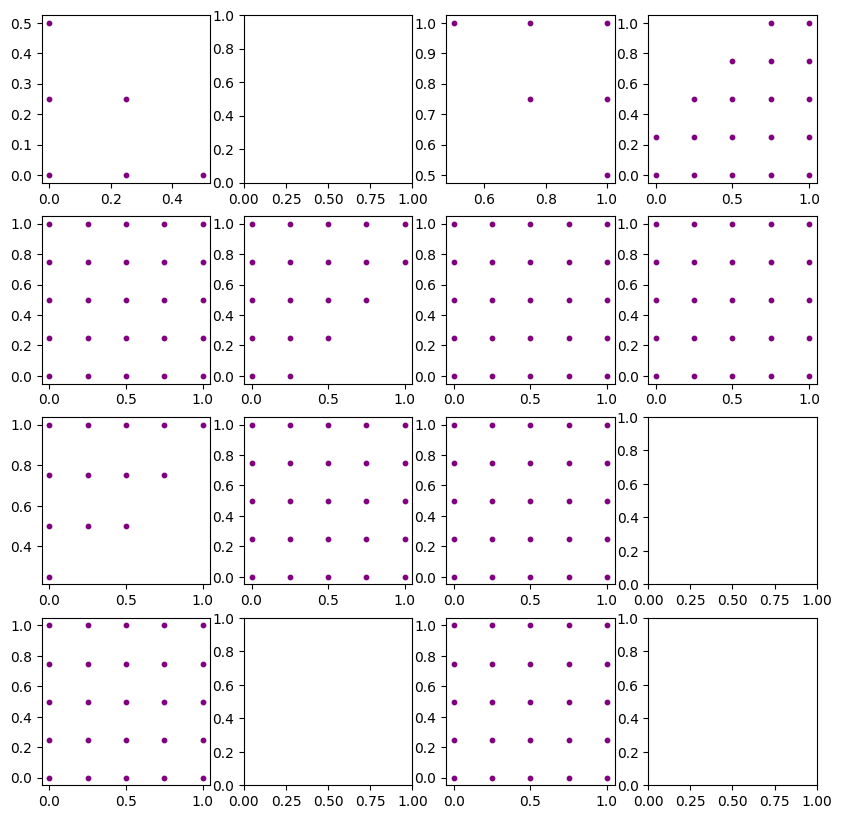

In [41]:
fig, axes = plt.subplots(4, 4, figsize=(10, 10))
axes = axes.flatten()

for i in range(acts.shape[1]):
    for pair, act in zip(pairs, acts):
        if act[i] > 0:
            axes[i].scatter(*pair, c="purple", s=10)

Ok so there seems to be redundancy here as it's evident that some of the neurons do not fire at all...

I think I'm going to try with fewer dimensions to see if this might force the network to distribute more.

In [19]:
# torch.save(model.state_dict(), 'models/e-3-.pth')